### How to open a github ipynb in google colab?

Replacing `https://github.com` by `https://colab.research.google.com/github` as mentioned in [stackoverflow](https://stackoverflow.com/questions/62596466/how-can-i-run-notebooks-of-a-github-project-in-google-colab)

In [1]:
%matplotlib inline

In [2]:
# # if run in Google colab
# !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
# #!cd data && unzip PennFudanPed.zip
# !cd data
# !nohup unzip data/PennFudanPed.zip

# !git clone https://github.com/s-reaungamornrat/video_processing.git

# main_dirpath=''

In [3]:
import os
import sys
import wget
sys.path.append('../../../')

main_dirpath=r'D:\data'

In [4]:
from video_processing.mask_rcnn.utils.utils import read_annotation, display_image_overlay

image  <class 'torch.Tensor'> torch.Size([3, 438, 567]) torch.uint8
mask  <class 'torch.Tensor'> torch.Size([1, 438, 567]) torch.uint8
{'obj_num': [1, 2, 3, 4], 'label': ['PASpersonWalking', 'PASpersonWalking', 'PASpersonStanding', 'PASpersonWalking'], 'bbox': [[[178, 123], [271, 410]], [[299, 114], [370, 335]], [[446, 104], [507, 315]], [[521, 119], [565, 258]]]}


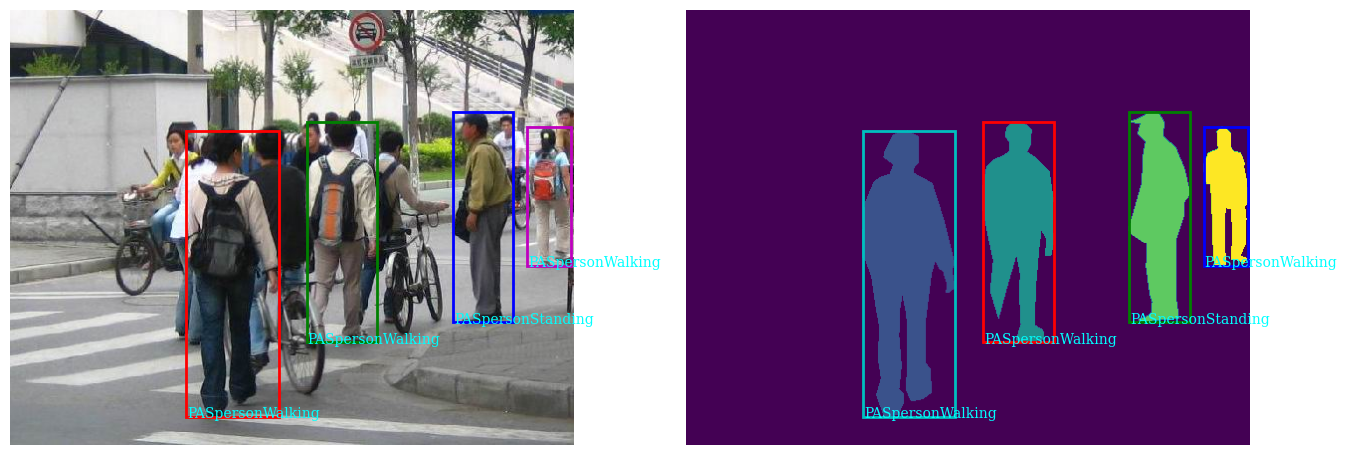

In [5]:
from torchvision.io import read_image

image=read_image(os.path.join(main_dirpath, 'PennFudanPed/PNGImages/FudanPed00046.png')) # CxHxW -> CxYxX
mask=read_image(os.path.join(main_dirpath, 'PennFudanPed/PedMasks/FudanPed00046_mask.png')) # CxHxW -> CxYxX
print('image ', type(image), image.shape, image.dtype)
print('mask ', type(mask), mask.shape, mask.dtype)

annotation=read_annotation(os.path.join(main_dirpath, 'PennFudanPed/Annotation/FudanPed00046.txt'))
print(annotation)
display_image_overlay(image=image, mask=mask, annotation=annotation)

In [6]:
import os
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

main_url='https://raw.githubusercontent.com/pytorch/vision/main/references/detection'
for file in ['engine.py', 'utils.py','coco_utils.py','coco_eval.py', 'transforms.py']:
    if os.path.isfile(file): continue
    out=wget.download(url=f'{main_url}/{file}', out=None)
    print(file, out)

In [7]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device ', device)

num_classes=2
# load an instance segmentation model pre-trained on COCO
model=torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='DEFAULT', rpn_pre_nms_top_n_train=800,
        rpn_pre_nms_top_n_test=500,  rpn_post_nms_top_n_train=800,  rpn_post_nms_top_n_test=500, box_detections_per_img=100,
        box_batch_size_per_image =400, rpn_batch_size_per_image=100)
# get number of input features for the classifier
in_features=model.roi_heads.box_predictor.cls_score.in_features
print('the number of inpute features for classifiers ', in_features)
# replace the pre-trained head with a new one
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,  num_classes)

# get the number of input features for the mask classifiers
in_features_mask=model.roi_heads.mask_predictor.conv5_mask.in_channels
print('the number of input features for mask ', in_features_mask)
hidden_layer=256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor=MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# move model to the right device
model.to(device);

device  cpu
the number of inpute features for classifiers  1024
the number of input features for mask  256


In [8]:
import torch

import utils
from video_processing.mask_rcnn.dataset.penn_fudan_ped import PennFudanDataset, get_transform

train_dataset=PennFudanDataset(root=os.path.join(main_dirpath, 'PennFudanPed'), image_dirname='PNGImages', mask_dirname='PedMasks',
                               annotation_dirname='Annotation', transforms=get_transform(is_train=True))#, image_mean=model.transform.image_mean, image_std=model.transform.image_std,
                                                  #min_size=model.transform.min_size, max_size=model.transform.max_size))

# define training and validation data loaders
tarin_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2,shuffle=True,collate_fn=utils.collate_fn)

2  images  [torch.Size([3, 454, 388]), torch.Size([3, 348, 342])] [(torch.float32, tensor(0.), tensor(1.)), (torch.float32, tensor(0.), tensor(1.))]
2  targets  [{'boxes': torch.Size([2, 4]), 'masks': torch.Size([2, 454, 388]), 'labels': torch.Size([2]), 'image_id': 7, 'area': torch.Size([2]), 'iscrowd': torch.Size([2])}, {'boxes': torch.Size([1, 4]), 'masks': torch.Size([1, 348, 342]), 'labels': torch.Size([1]), 'image_id': 149, 'area': torch.Size([1]), 'iscrowd': torch.Size([1])}]
masks  [(torch.uint8, tensor(0, dtype=torch.uint8), tensor(1, dtype=torch.uint8)), (torch.uint8, tensor(0, dtype=torch.uint8), tensor(1, dtype=torch.uint8))]


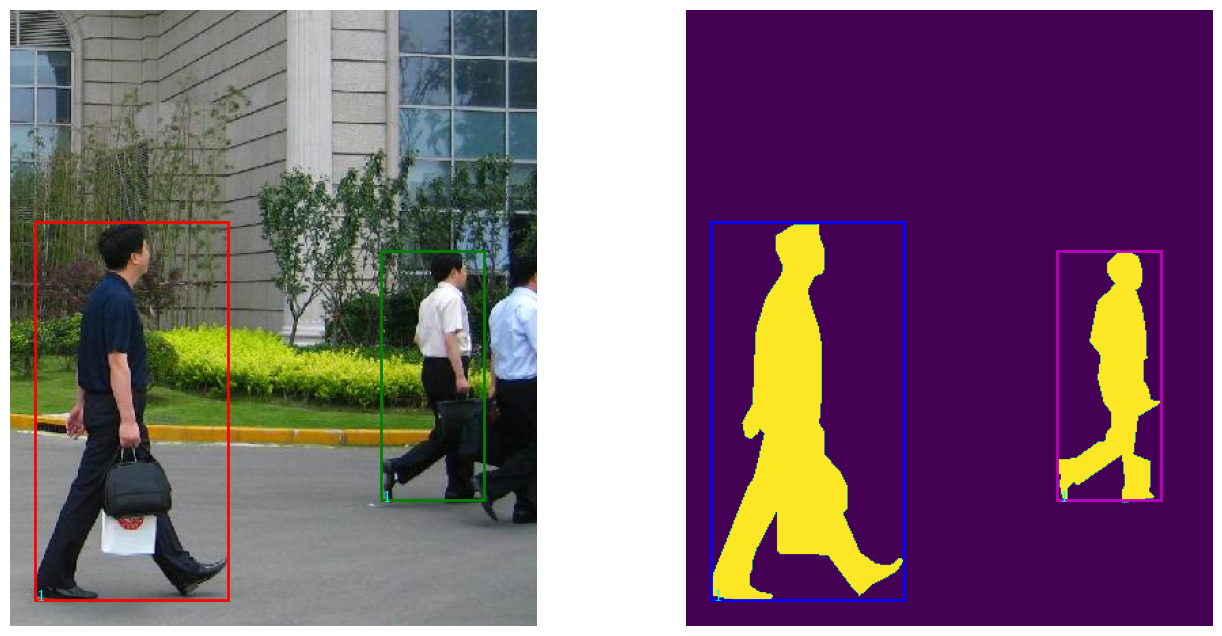

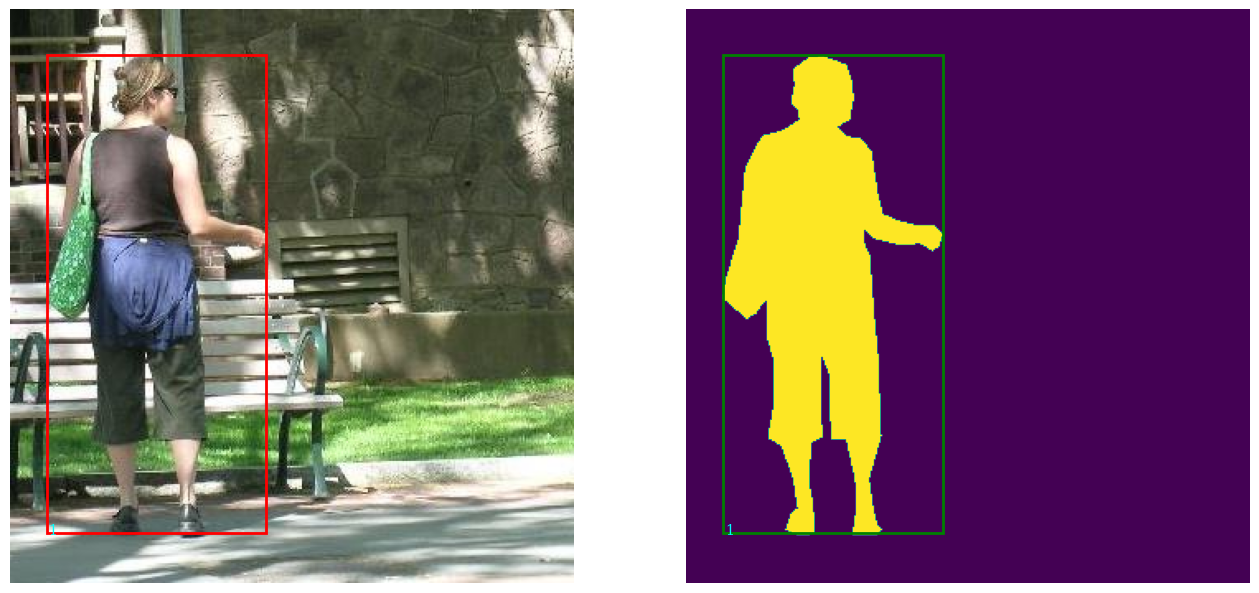

In [9]:
# For training
images, targets=next(iter(tarin_loader))
print(len(images), ' images ', [x.shape for x in images], [(x.dtype, x.min(), x.max()) for x in images])
print(len(targets), ' targets ', [{k:(v if not isinstance(v, torch.Tensor) else v.shape) for k, v in target.items()} for target in targets])
print('masks ', [(target['masks'].dtype, target['masks'].min(), target['masks'].max()) for target in targets])


for i in range(len(images)):
    annotation={'bbox':[[box.squeeze()[2*i:(2*i+2)] for i in range(2)] for box in targets[i]['boxes'].split(1, dim=0)],
              'label':[f'{l}' for l in targets[i]['labels']]}
    display_image_overlay(image=(images[i]*255).type(torch.uint8), mask=targets[i]['masks'].sum(dim=0, keepdim=True), annotation=annotation)

### Training `forward()`

In [10]:
# check that bounding box size is correct
for target in targets:
    boxes=target['boxes']
    if isinstance(boxes, torch.Tensor):
        assert(len(boxes.shape)==2 and boxes.shape[-1]==4), f'Expected target boxes to be a tensor of shape [N,4], got {boxes.shape}'
    else:
        assert False, f'Expected target boxes to be of type Tensor, got {type(boxes)}.'

In [11]:
# check for degenerate boxes
for target_idx, target in enumerate(targets):
    boxes=target['boxes']
    # Nx2 because this check element wise whether x2, y2 <= x1, y1
    degenerate_boxes=boxes[:,2:]<=boxes[:, :2]
    if degenerate_boxes.any():
        bb_idx=torch.where(degenerate_boxes.any(dim=1)) # which box in N and which dimension, e.g., box 1 along y dim
        degen_bb=boxes[bb_idx].tolist()
        assert False, f'All bounding boxes should have positive height and width\nFound invalid box {degen_bb} for target at index {target_idx}'

In [12]:
original_image_sizes=[]
for img in images:
    size=img.shape[-2:]
    print(img.shape, img.min(), img.max())
    assert len(size)==2, f'Expect the last two dimensions of the Tensor to be H and W, but got {img.shape[-2:]} instead'
    original_image_sizes.append((size[0], size[1]))
print('original_image_sizes ', original_image_sizes)

torch.Size([3, 454, 388]) tensor(0.) tensor(1.)
torch.Size([3, 348, 342]) tensor(0.) tensor(1.)
original_image_sizes  [(454, 388), (348, 342)]


In [13]:
targets[0]['boxes'], targets[0]['area']

(tensor([[ 19., 157., 161., 435.],
         [274., 178., 350., 362.]]),
 tensor([39476., 13984.]))

In [14]:
images_, targets_ = model.transform(images, targets)
print('image size ', images_.image_sizes)
print('images_ ', images_.tensors.shape, images_.tensors.min(), images_.tensors.max())
for i in range(len(targets_)):
    print('targets_ ', {k:(v.shape, v.min(), v.max(), v.dtype) if isinstance(v,torch.Tensor) else v for k, v in targets_[0].items()})
targets_[0]['boxes']

image size  [(936, 799), (814, 800)]
images_  torch.Size([2, 3, 960, 800]) tensor(-2.1150) tensor(2.6400)
targets_  {'boxes': (torch.Size([2, 4]), tensor(39.1263), tensor(896.8282), torch.float32), 'masks': (torch.Size([2, 936, 799]), tensor(0, dtype=torch.uint8), tensor(1, dtype=torch.uint8), torch.uint8), 'labels': (torch.Size([2]), tensor(1), tensor(1), torch.int64), 'image_id': 7, 'area': (torch.Size([2]), tensor(13984.), tensor(39476.), torch.float32), 'iscrowd': (torch.Size([2]), tensor(0), tensor(0), torch.int64)}
targets_  {'boxes': (torch.Size([2, 4]), tensor(39.1263), tensor(896.8282), torch.float32), 'masks': (torch.Size([2, 936, 799]), tensor(0, dtype=torch.uint8), tensor(1, dtype=torch.uint8), torch.uint8), 'labels': (torch.Size([2]), tensor(1), tensor(1), torch.int64), 'image_id': 7, 'area': (torch.Size([2]), tensor(13984.), tensor(39476.), torch.float32), 'iscrowd': (torch.Size([2]), tensor(0), tensor(0), torch.int64)}


tensor([[ 39.1263, 323.6828, 331.5438, 896.8282],
        [564.2422, 366.9780, 720.7474, 746.3260]])

### Backbone Body

The `forward` function is from [`generalized_rcnn.py`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/generalized_rcnn.py) which is the base class of [`FasterRCNN`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py) and [`MaskRCNN`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/mask_rcnn.py).

The `backbone` with `fpn` is defined in [`backbone_utils.py`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/backbone_utils.py)

In [15]:
from collections import OrderedDict

x=images_.tensors
print('x ', x.shape, x.min(), x.max())
print('return layers ', model.backbone.body.return_layers)
# we first pass the input images to body in the backbone (i.e., not FPN)
out = OrderedDict()
for name, module in model.backbone.body.items():
    x = module(x)
    print(name, x.shape)
    if name in model.backbone.body.return_layers:
        out_name = model.backbone.body.return_layers[name]
        out[out_name] = x
        print(name, out_name, x.shape)
print('\n\nout ', {k:(x.shape, x.min(), x.max(), x.dtype) for k, x in out.items()})

x  torch.Size([2, 3, 960, 800]) tensor(-2.1150) tensor(2.6400)
return layers  {'layer1': '0', 'layer2': '1', 'layer3': '2', 'layer4': '3'}
conv1 torch.Size([2, 64, 480, 400])
bn1 torch.Size([2, 64, 480, 400])
relu torch.Size([2, 64, 480, 400])
maxpool torch.Size([2, 64, 240, 200])
layer1 torch.Size([2, 256, 240, 200])
layer1 0 torch.Size([2, 256, 240, 200])
layer2 torch.Size([2, 512, 120, 100])
layer2 1 torch.Size([2, 512, 120, 100])
layer3 torch.Size([2, 1024, 60, 50])
layer3 2 torch.Size([2, 1024, 60, 50])
layer4 torch.Size([2, 2048, 30, 25])
layer4 3 torch.Size([2, 2048, 30, 25])


out  {'0': (torch.Size([2, 256, 240, 200]), tensor(0.), tensor(3.5626), torch.float32), '1': (torch.Size([2, 512, 120, 100]), tensor(0., grad_fn=<MinBackward1>), tensor(3.3273, grad_fn=<MaxBackward1>), torch.float32), '2': (torch.Size([2, 1024, 60, 50]), tensor(0., grad_fn=<MinBackward1>), tensor(2.6675, grad_fn=<MaxBackward1>), torch.float32), '3': (torch.Size([2, 2048, 30, 25]), tensor(0., grad_fn=<MinB

### Backbone FPN

Based on code at [`feature_pyramid_network.py`](https://github.com/pytorch/vision/blob/main/torchvision/ops/feature_pyramid_network.py#L183), where `extra_blocks` from [`LastLevelMaxPool`](https://github.com/pytorch/vision/blob/main/torchvision/ops/feature_pyramid_network.py)


In [16]:
import torch.nn.functional as F

# we then pass feature to FPN
x=out
names=list(x.keys())
x=list(x.values())
print('names ', names)
print('x ', [i.shape for i in x])

# we move from the output from the backbone-body deepest layer (having the bigger number of channels)
last_inner=model.backbone.fpn.inner_blocks[-1](x[-1])
print('last_inner ', last_inner.shape, last_inner.min(), last_inner.max())
results=[model.backbone.fpn.layer_blocks[-1](last_inner)]
print('last result ', results[0].shape, results[0].min(), results[0].max())

# we get from the one after deepest layer (i.e., top down)
for idx in range(len(x)-2, -1, -1):
    inner_lateral=model.backbone.fpn.inner_blocks[idx](x[idx])
    feat_shape=inner_lateral.shape[-2:]
    inner_top_down = F.interpolate(last_inner, size=feat_shape, mode="nearest")
    print(idx, ' last_inner ', last_inner.shape, ' feat_shape ', feat_shape, end=',')
    last_inner=inner_lateral+inner_top_down
    results.insert(0, model.backbone.fpn.layer_blocks[idx](last_inner))
    print(' updated_last_inner ', last_inner.shape, ' result ', results[0].shape)

print('\n\nresults ', [(r.shape, r.min(), r.max()) for r in results])

results, names =model.backbone.fpn.extra_blocks(results, x, names)

print('\n\nname:results ', {n:(r.shape, r.min(), r.max()) for n, r in zip(names,results)})

# make it back an OrderedDict
out=OrderedDict([(k,v) for k, v in zip(names, results)])

names  ['0', '1', '2', '3']
x  [torch.Size([2, 256, 240, 200]), torch.Size([2, 512, 120, 100]), torch.Size([2, 1024, 60, 50]), torch.Size([2, 2048, 30, 25])]
last_inner  torch.Size([2, 256, 30, 25]) tensor(-1.3256, grad_fn=<MinBackward1>) tensor(1.1562, grad_fn=<MaxBackward1>)
last result  torch.Size([2, 256, 30, 25]) tensor(-1.5894, grad_fn=<MinBackward1>) tensor(2.4710, grad_fn=<MaxBackward1>)
2  last_inner  torch.Size([2, 256, 30, 25])  feat_shape  torch.Size([60, 50]), updated_last_inner  torch.Size([2, 256, 60, 50])  result  torch.Size([2, 256, 60, 50])
1  last_inner  torch.Size([2, 256, 60, 50])  feat_shape  torch.Size([120, 100]), updated_last_inner  torch.Size([2, 256, 120, 100])  result  torch.Size([2, 256, 120, 100])
0  last_inner  torch.Size([2, 256, 120, 100])  feat_shape  torch.Size([240, 200]), updated_last_inner  torch.Size([2, 256, 240, 200])  result  torch.Size([2, 256, 240, 200])


results  [(torch.Size([2, 256, 240, 200]), tensor(-2.0120, grad_fn=<MinBackward1>), ten

### Region Proposal Network (RPN)

This is for the line
```
proposals, proposal_losses = self.rpn(images, features, targets)
```
in [`generalized_rcnn.py`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/generalized_rcnn.py) which calls `rpn` defined on [`rpn.py`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py)

In [17]:
import numpy as np

In [18]:
# RPN uses all feature maps that are available
features=list(out.values()) # output from FPN
print('features ', [f.shape for f in features])

# call RPNHead
objectness=[] # logits
pred_bbox_deltas=[] # bbox_reg
for i, feature in enumerate(features):
    t=model.rpn.head.conv(feature)
    objectness.append(model.rpn.head.cls_logits(t))
    pred_bbox_deltas.append(model.rpn.head.bbox_pred(t)) # predict dx,dy,dw,dh
    print(i, ' feature ', feature.shape, ' t ', t.shape, ' objectness ', objectness[-1].shape, objectness[-1].min().item(),
          objectness[-1].max().item(), ' pred_bbox_deltas ', pred_bbox_deltas[-1].shape, pred_bbox_deltas[-1].min().item(),
          pred_bbox_deltas[-1].max().item())

features  [torch.Size([2, 256, 240, 200]), torch.Size([2, 256, 120, 100]), torch.Size([2, 256, 60, 50]), torch.Size([2, 256, 30, 25]), torch.Size([2, 256, 15, 13])]
0  feature  torch.Size([2, 256, 240, 200])  t  torch.Size([2, 256, 240, 200])  objectness  torch.Size([2, 3, 240, 200]) -25.541318893432617 5.572510719299316  pred_bbox_deltas  torch.Size([2, 12, 240, 200]) -2.668363094329834 2.3729405403137207
1  feature  torch.Size([2, 256, 120, 100])  t  torch.Size([2, 256, 120, 100])  objectness  torch.Size([2, 3, 120, 100]) -25.24054718017578 4.813629627227783  pred_bbox_deltas  torch.Size([2, 12, 120, 100]) -1.7448351383209229 1.9099886417388916
2  feature  torch.Size([2, 256, 60, 50])  t  torch.Size([2, 256, 60, 50])  objectness  torch.Size([2, 3, 60, 50]) -26.619840621948242 9.364811897277832  pred_bbox_deltas  torch.Size([2, 12, 60, 50]) -1.7489047050476074 1.4228646755218506
3  feature  torch.Size([2, 256, 30, 25])  t  torch.Size([2, 256, 30, 25])  objectness  torch.Size([2, 3, 30

In [19]:
# compute anchors
print('sizes  ', model.rpn.anchor_generator.sizes )
print('aspect_ratios ', model.rpn.anchor_generator.aspect_ratios)
print(len(model.rpn.anchor_generator.cell_anchors), ' cell_anchors  ', [an.shape for an in model.rpn.anchor_generator.cell_anchors],
      model.rpn.anchor_generator.cell_anchors[0] )

grid_sizes=[feature.shape[-2:] for feature in features] # grid size of output features from FPN
image_size=images_.tensors.shape[-2:]
print('\ngrid_size ', grid_sizes, ' image_size ', image_size)
dtype,device=features[0].dtype, features[0].device
strides=[
    [torch.empty((), dtype=torch.int64, device=device).fill_(image_size[0]//g[0]),
     torch.empty((), dtype=torch.int64, device=device).fill_(image_size[1]//g[1])]
    for g in grid_sizes
]
print('stride ', strides)
# set model.rpn.anchor_generator.cell_anchors to dtype and move them to device
model.rpn.anchor_generator.set_cell_anchors(dtype, device)
anchors_over_all_feature_maps=model.rpn.anchor_generator.grid_anchors(grid_sizes, strides)
print('anchors_over_all_feature_maps ', len(anchors_over_all_feature_maps), [x.shape for x in anchors_over_all_feature_maps])

sizes   ((32,), (64,), (128,), (256,), (512,))
aspect_ratios  ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
5  cell_anchors   [torch.Size([3, 4]), torch.Size([3, 4]), torch.Size([3, 4]), torch.Size([3, 4]), torch.Size([3, 4])] tensor([[-23., -11.,  23.,  11.],
        [-16., -16.,  16.,  16.],
        [-11., -23.,  11.,  23.]])

grid_size  [torch.Size([240, 200]), torch.Size([120, 100]), torch.Size([60, 50]), torch.Size([30, 25]), torch.Size([15, 13])]  image_size  torch.Size([960, 800])
stride  [[tensor(4), tensor(4)], [tensor(8), tensor(8)], [tensor(16), tensor(16)], [tensor(32), tensor(32)], [tensor(64), tensor(61)]]
anchors_over_all_feature_maps  5 [torch.Size([144000, 4]), torch.Size([36000, 4]), torch.Size([9000, 4]), torch.Size([2250, 4]), torch.Size([585, 4])]


In [20]:
for i, (feat, ancs) in enumerate(zip(features, anchors_over_all_feature_maps)):
    # where 3 is the number of anchors
    print(i, feat.shape[-2:], np.prod(feat.shape[-2:]), np.prod(feat.shape[-2:])*3, ancs.shape)

0 torch.Size([240, 200]) 48000 144000 torch.Size([144000, 4])
1 torch.Size([120, 100]) 12000 36000 torch.Size([36000, 4])
2 torch.Size([60, 50]) 3000 9000 torch.Size([9000, 4])
3 torch.Size([30, 25]) 750 2250 torch.Size([2250, 4])
4 torch.Size([15, 13]) 195 585 torch.Size([585, 4])


In [21]:
print('images_.image_sizes ', images_.image_sizes)
anchors=[]
for _ in range(images_.tensors.shape[0]):
    anchors_in_image=[anchors_per_feature_map for anchors_per_feature_map in anchors_over_all_feature_maps]
    print('anchors_in_image ', len(anchors_in_image), [i.shape for i in anchors_in_image])
    anchors.append(anchors_in_image)
anchors=[torch.cat(anchors_per_image) for anchors_per_image in anchors]
print('anchors ', len(anchors), [a.shape for a in anchors])
torch.save(anchors, 'anchors.pt')

images_.image_sizes  [(936, 799), (814, 800)]
anchors_in_image  5 [torch.Size([144000, 4]), torch.Size([36000, 4]), torch.Size([9000, 4]), torch.Size([2250, 4]), torch.Size([585, 4])]
anchors_in_image  5 [torch.Size([144000, 4]), torch.Size([36000, 4]), torch.Size([9000, 4]), torch.Size([2250, 4]), torch.Size([585, 4])]
anchors  2 [torch.Size([191835, 4]), torch.Size([191835, 4])]


In [22]:
num_images=len(anchors)
print('num_images ', num_images)
num_anchors_per_level_shape_tensors=[o.shape[1:] for o in objectness] # we note that o at each level is of size BxCxHxW -->  ot sure what C is? classes, num_anchors, ...?
print('num_anchors_per_level_shape_tensors ', num_anchors_per_level_shape_tensors)
num_anchors_per_level=[np.prod(s) for s in num_anchors_per_level_shape_tensors]
print('num_anchors_per_level ', num_anchors_per_level)

num_images  2
num_anchors_per_level_shape_tensors  [torch.Size([3, 240, 200]), torch.Size([3, 120, 100]), torch.Size([3, 60, 50]), torch.Size([3, 30, 25]), torch.Size([3, 15, 13])]
num_anchors_per_level  [np.int64(144000), np.int64(36000), np.int64(9000), np.int64(2250), np.int64(585)]


In [23]:
def permute_and_flatten(layer, N, A, C, H, W):
    '''
    Change the shape of a tensor having batch size of N, height H, width W, number of anchors A, and number of channels
    to a tensor of size Nx(HWA)xC
    Input:
        layer (tensor): whose dimension must comprise N, A, C, H, W
        N (int): batch size
        A (int): number of anchors, typically equal the number of aspect ratios
        C (int): number of channels
        H (int): height
        W (int): width
    '''
    layer = layer.view(N, -1, C, H, W) # NxAxCxHxW
    layer = layer.permute(0, 3, 4, 1, 2) # NxHxWxAxC
    layer = layer.reshape(N, -1, C) # Nx(HWA)xC
    return layer

In [24]:
# The following code for the following function in https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py
#objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
box_cls=objectness
box_regression=pred_bbox_deltas

box_cls_flattened=[]
box_regression_flattened=[]
# for each feature level, permute the outputs to make them be in the same format as the labels. Note that the labels are computed for all
# feature levels concatenated, so we keep the same representation for the objectness and the box_regiression
for box_cls_per_level, box_regression_per_level in zip(box_cls, box_regression):
    N, AxC, H, W=box_cls_per_level.shape
    Ax4=box_regression_per_level.shape[1]
    A=Ax4//4
    C=AxC//A
    print('A ', A, ' C ', C, 'box_cls_per_level ', box_cls_per_level.shape, ' box_regression_per_level ', box_regression_per_level.shape)
    box_cls_per_level=permute_and_flatten(box_cls_per_level, N, A, C, H, W) # NxHWAxC
    box_cls_flattened.append(box_cls_per_level)


    box_regression_per_level = permute_and_flatten(box_regression_per_level, N, A, 4, H, W) # NxHWAxC
    box_regression_flattened.append(box_regression_per_level)
print('\nbox_cls_flattened ', len(box_cls_flattened), [i.shape for i in box_cls_flattened])
print('box_regression_flattened ', len(box_regression_flattened), [i.shape for i in box_regression_flattened])

# concatenate on the first dimension (representing the feature levels), to take into account the way the labels were generated (with all feature maps being concatenated as well)
box_cls_=torch.cat(box_cls_flattened, dim=1).flatten(start_dim=0, end_dim=-2) # Nx(HWA)xC -> NHWAxC
box_regression_=torch.cat(box_regression_flattened, dim=1).reshape(-1, 4) # Nx(HWA)xC -> NHWAxC
print('box_cls_ ', box_cls_.shape, box_cls_.requires_grad, box_cls_.dtype, box_cls_.min(), box_cls_.max())
print('box_regression_ ', box_regression_.shape, box_regression_.requires_grad, box_regression_.dtype, box_regression_.min(0).values,
      box_regression_.max(dim=0).values)

# torch.save(box_regression_, 'pred_bbox_deltas.pt')

A  3  C  1 box_cls_per_level  torch.Size([2, 3, 240, 200])  box_regression_per_level  torch.Size([2, 12, 240, 200])
A  3  C  1 box_cls_per_level  torch.Size([2, 3, 120, 100])  box_regression_per_level  torch.Size([2, 12, 120, 100])
A  3  C  1 box_cls_per_level  torch.Size([2, 3, 60, 50])  box_regression_per_level  torch.Size([2, 12, 60, 50])
A  3  C  1 box_cls_per_level  torch.Size([2, 3, 30, 25])  box_regression_per_level  torch.Size([2, 12, 30, 25])
A  3  C  1 box_cls_per_level  torch.Size([2, 3, 15, 13])  box_regression_per_level  torch.Size([2, 12, 15, 13])

box_cls_flattened  5 [torch.Size([2, 144000, 1]), torch.Size([2, 36000, 1]), torch.Size([2, 9000, 1]), torch.Size([2, 2250, 1]), torch.Size([2, 585, 1])]
box_regression_flattened  5 [torch.Size([2, 144000, 4]), torch.Size([2, 36000, 4]), torch.Size([2, 9000, 4]), torch.Size([2, 2250, 4]), torch.Size([2, 585, 4])]
box_cls_  torch.Size([383670, 1]) True torch.float32 tensor(-26.6198, grad_fn=<MinBackward1>) tensor(9.8121, grad_fn

[`BoxCoder`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/_utils.py)

we check `BoxCoder` using local machine

In [25]:
# NHWAxC, NHWAx4C,
objectness, pred_bbox_deltas=box_cls_,box_regression_
print(f'objectness {objectness.shape}, pred_bbox_deltas {pred_bbox_deltas.shape}')
# apply pred_bbox_deltas to anchors to obtain the decoded proposals
# note that we detach the deltas because Faster R-CNN do not backprop through
# the proposals
proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors) # NHWAx4C
print('proposals ', proposals.shape)
proposals = proposals.view(num_images, -1, 4) #NxHWAx4C
print('proposals ', proposals.shape)

objectness torch.Size([383670, 1]), pred_bbox_deltas torch.Size([383670, 4])
proposals  torch.Size([383670, 1, 4])
proposals  torch.Size([2, 191835, 4])


### Test [`filter_proposals`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py) in notebook

```
boxes, scores = self.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)
```

In [26]:
# torch.save(proposals, "proposals.pt")
# torch.save(objectness, "objectness.pt")
print('num_anchors_per_level ', num_anchors_per_level)
print('image_sizes ', images_.image_sizes)
print('_pre_nms_top_n ', model.rpn._pre_nms_top_n)
print('score_thresh ', model.rpn.score_thresh, ' nms_thresh ', model.rpn.nms_thresh)
print('_post_nms_top_n ', model.rpn._post_nms_top_n)
print('min_size ', model.rpn.min_size)

num_anchors_per_level  [np.int64(144000), np.int64(36000), np.int64(9000), np.int64(2250), np.int64(585)]
image_sizes  [(936, 799), (814, 800)]
_pre_nms_top_n  {'training': 800, 'testing': 500}
score_thresh  0.0  nms_thresh  0.7
_post_nms_top_n  {'training': 800, 'testing': 500}
min_size  0.001


In [27]:
boxes, scores = model.rpn.filter_proposals(proposals, objectness, images_.image_sizes,
                                           num_anchors_per_level)
print('boxes ', type(boxes), len(boxes), [(b.shape, b.min(0).values, b.max(0).values) for b in boxes])
print('scores ', type(scores), len(scores), [(s.shape, s.min(), s.max()) for s in scores] )

boxes  <class 'list'> 2 [(torch.Size([800, 4]), tensor([ 0.0000,  0.0000,  2.6861, 66.9277]), tensor([797.3220, 930.8621, 799.0000, 936.0000])), (torch.Size([800, 4]), tensor([0.0000, 0.0000, 3.4495, 6.1706]), tensor([790.9858, 695.4841, 800.0000, 814.0000]))]
scores  <class 'list'> 2 [(torch.Size([800]), tensor(0.0087), tensor(0.9999)), (torch.Size([800]), tensor(0.0336), tensor(0.9999))]


### Test [`assign_targets_to_anchors`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py#L193) in notebook

```
labels, matched_gt_boxes = self.assign_targets_to_anchors(anchors, targets)
```

In [28]:
# print('targets ', [t['boxes'].shape for t in targets])
# print('anchors ', [a.shape for a in anchors])
# torch.save({'targets':targets, 'anchors':anchors} , 'assign_targets_to_anchors.pt')


In [29]:
labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
print('labels ', [(l.shape, l.min().item(), l.max().item()) for l in labels])
print('matched_gt_boxes ', [(m.shape, m.min().item(), m.max().item()) for m in matched_gt_boxes])

labels  [(torch.Size([191835]), -1.0, 1.0), (torch.Size([191835]), -1.0, 1.0)]
matched_gt_boxes  [(torch.Size([191835, 4]), 19.0, 435.0), (torch.Size([191835, 4]), 23.0, 318.0)]


### Test [`box_coder.encode`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/_utils.py) in notebook

For the [line](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py#L193)

```
regression_targets = self.box_coder.encode(matched_gt_boxes, anchors)
```

In [30]:
# torch.save({'matched_gt_boxes':matched_gt_boxes, 'anchors':anchors}, 'box_coder_encoder.pt')
regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
print('regression_targets ', len(regression_targets), [r.shape for r in regression_targets])

regression_targets  2 [torch.Size([191835, 4]), torch.Size([191835, 4])]


### Compute [`loss`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py#L299)

This computes [`loss`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py#L193)
```
loss_objectness, loss_rpn_box_reg = self.compute_loss(
                objectness, pred_bbox_deltas, labels, regression_targets
            )
```

### Test [`BalancedPositiveNegativeSampler`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/_utils.py)

For
```
self.fg_bg_sampler = det_utils.BalancedPositiveNegativeSampler(batch_size_per_image, positive_fraction)
```
in [`compute_loss`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py#L143)
```
sampled_pos_inds, sampled_neg_inds = self.fg_bg_sampler(labels)
```

In [31]:
print('objectness ', objectness.shape, objectness.min().item(), objectness.max().item())
print('pred_bbox_deltas ', pred_bbox_deltas.shape, pred_bbox_deltas.min(0).values,
      pred_bbox_deltas.max(0).values)
print('labels ', len(labels), [(l.shape, l.min().item(), l.max().item()) for l in labels])
print('regression_targets ',len(regression_targets), [(r.shape, r.min(0).values,
      r.max(0).values) for r in regression_targets])
# torch.save(labels, 'labels.pt')

objectness  torch.Size([383670, 1]) -26.619840621948242 9.812063217163086
pred_bbox_deltas  torch.Size([383670, 4]) tensor([-0.8542, -1.5964, -2.6684, -2.4951], grad_fn=<MinBackward0>) tensor([0.7385, 1.2704, 1.9213, 2.3729], grad_fn=<MaxBackward0>)
labels  2 [(torch.Size([191835]), -1.0, 1.0), (torch.Size([191835]), -1.0, 1.0)]
regression_targets  2 [(torch.Size([191835, 4]), tensor([-32.0909, -30.0000,  -1.6290,  -0.9572]), tensor([ 4.0909, 13.4545,  1.8648,  2.5366])), (torch.Size([191835, 4]), tensor([-32.1136, -35.5909,  -1.6944,  -0.9149]), tensor([4.0682, 7.8636, 1.7993, 2.5788]))]


In [32]:
print('model.rpn.fg_bg_sampler.batch_size_per_image ', model.rpn.fg_bg_sampler.batch_size_per_image)
print('model.rpn.fg_bg_sampler.positive_fraction ', model.rpn.fg_bg_sampler.positive_fraction)

model.rpn.fg_bg_sampler.batch_size_per_image  100
model.rpn.fg_bg_sampler.positive_fraction  0.5


In [33]:
sampled_pos_inds, sampled_neg_inds=model.rpn.fg_bg_sampler(labels)
print('sampled_pos_inds ', [p.shape for p in sampled_pos_inds])
print('sampled_neg_inds ', [p.shape for p in sampled_neg_inds])
sampled_pos_inds=torch.nonzero(torch.cat(sampled_pos_inds, dim=0), as_tuple=True)[0]
sampled_neg_inds=torch.nonzero(torch.cat(sampled_neg_inds, dim=0), as_tuple=True)[0]
print('sampled_pos_inds ', sampled_pos_inds.shape, sampled_pos_inds.min(), sampled_pos_inds.max(),
      '\nsampled_neg_inds ', sampled_neg_inds.shape, sampled_neg_inds.min(), sampled_neg_inds.max())
sampled_inds=torch.cat([sampled_pos_inds, sampled_neg_inds], dim=0)
print('sampled_inds ', sampled_inds.shape, sampled_inds.min(), sampled_inds.max())

objectness = objectness.flatten() # NHWAxC -> NHWAC but C=1

labels=torch.cat(labels, dim=0) # from list of 1D tensor to 1D concatenated tensor
regression_targets=torch.cat(regression_targets, dim=0)

sampled_pos_inds  [torch.Size([191835]), torch.Size([191835])]
sampled_neg_inds  [torch.Size([191835]), torch.Size([191835])]
sampled_pos_inds  torch.Size([9]) tensor(182459) tensor(381296) 
sampled_neg_inds  torch.Size([191]) tensor(6587) tensor(382259)
sampled_inds  torch.Size([200]) tensor(6587) tensor(382259)


In [34]:
print('pred_bbox_deltas ', pred_bbox_deltas.shape, pred_bbox_deltas.min(0).values,
      pred_bbox_deltas.max(0).values)
print('regression_targets ', regression_targets.shape, regression_targets.min(0).values,
      regression_targets.max(0).values)

pred_bbox_deltas  torch.Size([383670, 4]) tensor([-0.8542, -1.5964, -2.6684, -2.4951], grad_fn=<MinBackward0>) tensor([0.7385, 1.2704, 1.9213, 2.3729], grad_fn=<MaxBackward0>)
regression_targets  torch.Size([383670, 4]) tensor([-32.1136, -35.5909,  -1.6944,  -0.9572]) tensor([ 4.0909, 13.4545,  1.8648,  2.5788])


In [35]:
box_loss=torch.nn.functional.smooth_l1_loss(pred_bbox_deltas[sampled_pos_inds],
                                            regression_targets[sampled_pos_inds], beta=1/9,
                                            reduction="sum")/(sampled_inds.numel())
print('box_loss ', box_loss)

box_loss  tensor(0.0290, grad_fn=<DivBackward0>)


In [36]:
objectness_loss=torch.nn.functional.binary_cross_entropy_with_logits(objectness[sampled_inds],
                                                                     labels[sampled_inds])
print('objectness_loss ', objectness_loss)

objectness_loss  tensor(0.2721, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [37]:
print('proposals ', [p.shape for p in proposals])

proposals  [torch.Size([191835, 4]), torch.Size([191835, 4])]


#### Get outcome from RPN to use in ROI head

In [38]:
proposals, proposal_losses = model.rpn(images_, out, targets)

In [39]:
print('proposals ', [p.shape for p in proposals])
print('proposal_losses ', proposal_losses)

proposals  [torch.Size([800, 4]), torch.Size([800, 4])]
proposal_losses  {'loss_objectness': tensor(0.2772, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0290, grad_fn=<DivBackward0>)}


### [ROI Head](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/generalized_rcnn.py)


In [40]:
for n, c in model.roi_heads.named_children():
    print(n)

box_roi_pool
box_head
box_predictor
mask_roi_pool
mask_head
mask_predictor


In [41]:
print('targets ', targets is not None)
for t in targets:
    floating_point_types=(torch.float, torch.double, torch.half)
    if t['boxes'].dtype not in floating_point_types:
        raise TypeError(f'target boxes must be of float type, instead got {t["boxes"].dtype}')
    if not t['labels'].dtype==torch.int64:
        raise TypeError(f'target labels must be of int64 type, instead got {t["labels"].dtype}')
    if model.roi_heads.has_keypoint():
        if not t["keypoints"].dtype==torch.float32:
            raise TypeError(f'target keypoints must be of float, instead got {t["keypoints"].dtype}')
    print('label ', t['labels'])

targets  True
label  tensor([1, 1])
label  tensor([1])


### Test [`select_training_samples`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py#L633)

Call in [`RoIHeads`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py)
```
proposals, matched_idxs, labels, regression_targets = self.select_training_samples(proposals, targets)
```

In [42]:
# for comparison
proposals_, matched_idxs_, labels_, regression_targets_ = model.roi_heads.select_training_samples(proposals, targets)

In [43]:
print('labels_ ', [l.shape for l in labels_])
print('regression_targets_ ', [r.shape for r in  regression_targets_])
print('proposals_ ', [p.shape for p in proposals_])

labels_  [torch.Size([400]), torch.Size([400])]
regression_targets_  [torch.Size([400, 4]), torch.Size([400, 4])]
proposals_  [torch.Size([400, 4]), torch.Size([400, 4])]


In [44]:
def check_targets(targets):
    '''
    targets List[Dict[str, Tensor]]
    '''
    if targets is None: raise ValueError('targets should not be None')
    if not all("boxes" in t for t in targets): raise ValueError('Every element of targets should have a boxes key')
    if not all("labels" in t for t in targets): raise ValueError('Every element of targets should have a labels key')
    if model.roi_heads.has_mask():
        if not all('masks' in t for t in targets): raise ValueError('Every element of targets should have a masks key')

In [45]:
check_targets(targets)
dtype=proposals[0].dtype
device=proposals[0].device

gt_boxes=[t["boxes"].to(dtype=dtype) for t in targets] # each of size Nx4, where N is the number of boxes
gt_labels=[t["labels"] for t in targets] # each 1D tensor
print('gt_boxes ', [b.shape for b in gt_boxes], gt_boxes)
print('gt_labels ', gt_labels) # each of size N, where N is the number of boxes

# append ground truth bboxes to proposals
# proposals = self.add_gt_proposals(proposals, gt_boxes)
print('proposals ', [p.shape for p in proposals])
proposals=[torch.cat((proposal, gt_box)) for proposal, gt_box in zip(proposals, gt_boxes)]
print('proposals ', [p.shape for p in proposals])

gt_boxes  [torch.Size([2, 4]), torch.Size([1, 4])] [tensor([[ 19., 157., 161., 435.],
        [274., 178., 350., 362.]]), tensor([[ 23.,  28., 156., 318.]])]
gt_labels  [tensor([1, 1]), tensor([1])]
proposals  [torch.Size([800, 4]), torch.Size([800, 4])]
proposals  [torch.Size([802, 4]), torch.Size([801, 4])]


In [46]:
print([p.requires_grad for p in proposals])

[False, False]


### Test [`RoIHeads.assign_targets_to_proposals`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py#L571)

Called in [`select_training_samples`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py#L633)

In [47]:
# torch.save({'gt_boxes':gt_boxes,'gt_labels':gt_labels, 'proposals':proposals},
#            'roi_head_assign_targets_to_proposal.pt')

In [48]:
# get matching ground truth indices for each proposal
matched_idxs, labels=model.roi_heads.assign_targets_to_proposals(proposals, gt_boxes, gt_labels)
# sample a fixed proportion of positive-negatibe proposals
# sampled_inds=self.subsample(labels) # below are from subsample(labels)
sampled_pos_inds, sample_neg_inds=model.roi_heads.fg_bg_sampler(labels)
sampled_inds=[]
for img_idx, (pos_inds_img, neg_inds_img) in enumerate(zip(sampled_pos_inds, sampled_neg_inds)):
    # replace the following by expressive commands
    #img_sampled_inds = torch.where(pos_inds_img | neg_inds_img)[0]
    img_sampled_inds=torch.nonzero(torch.bitwise_or(pos_inds_img, neg_inds_img), as_tuple=True)[0]
    sampled_inds.append(img_sampled_inds)
    print(img_idx, pos_inds_img.shape, pos_inds_img.dtype, pos_inds_img.min(), pos_inds_img.max())
    print('\t', neg_inds_img.shape, neg_inds_img.dtype, neg_inds_img.min(), neg_inds_img.max())
print('sampled_inds ', [s.shape for s in sampled_inds])

0 torch.Size([802]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)
	 torch.Size([]) torch.int64 tensor(6587) tensor(6587)
1 torch.Size([801]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)
	 torch.Size([]) torch.int64 tensor(7397) tensor(7397)
sampled_inds  [torch.Size([802]), torch.Size([801])]


In [49]:
print('matched_idxs ', [(m.shape, m.min().item(), m.max().item()) for m in matched_idxs])
print('labels ', [(l.shape, l.min().item(), l.max().item()) for l in labels])

matched_idxs  [(torch.Size([802]), 0, 1), (torch.Size([801]), 0, 0)]
labels  [(torch.Size([802]), 0, 1), (torch.Size([801]), 0, 1)]


In [50]:
matched_gt_boxes=[]
num_images=len(proposals)
print('num_images ', num_images)
for img_id in range(num_images):
    img_sampled_inds=sampled_inds[img_id]
    print('img_id ', img_id, '-'*50)
    print('\timg_sampled_inds ', img_sampled_inds.shape, ' proposals[img_id] ', proposals[img_id].shape)
    proposals[img_id]=proposals[img_id][img_sampled_inds]
    print('\tproposals[img_id] ', proposals[img_id].shape)
    labels[img_id]=labels[img_id][img_sampled_inds]
    matched_idxs[img_id]=matched_idxs[img_id][img_sampled_inds]

    gt_boxes_in_image=gt_boxes[img_id]
    if gt_boxes_in_image.numel()==0: gt_boxes_in_image=torch.zeros((1,4), dtype=dtype, device=device)
    matched_gt_boxes.append(gt_boxes_in_image[matched_idxs[img_id]])

print('matched_gt_boxes ', [(m.shape, m.min(), m.max().item()) for m in matched_gt_boxes])
print('proposals ', [(p.shape, p.min().item(),p.max().item()) for p in proposals])
regression_targets = model.roi_heads.box_coder.encode(matched_gt_boxes, proposals)

num_images  2
img_id  0 --------------------------------------------------
	img_sampled_inds  torch.Size([802])  proposals[img_id]  torch.Size([802, 4])
	proposals[img_id]  torch.Size([802, 4])
img_id  1 --------------------------------------------------
	img_sampled_inds  torch.Size([801])  proposals[img_id]  torch.Size([801, 4])
	proposals[img_id]  torch.Size([801, 4])
matched_gt_boxes  [(torch.Size([802, 4]), tensor(19.), 435.0), (torch.Size([801, 4]), tensor(23.), 318.0)]
proposals  [(torch.Size([802, 4]), 0.0, 936.0), (torch.Size([801, 4]), 0.0, 814.0)]


In [51]:
print('regression_targets ', [r.shape for r in regression_targets])
print('labels ', [(l.shape, l.min().item(), l.max().item()) for l in labels])

regression_targets  [torch.Size([802, 4]), torch.Size([801, 4])]
labels  [(torch.Size([802]), 0, 1), (torch.Size([801]), 0, 1)]


### Finish `select_training_samples`

We will perform the following lines inside `forward` of [RoiHeads](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py) lines 537
```
    box_features = self.box_roi_pool(features, proposals, image_shapes)
    box_features = self.box_head(box_features)
    class_logits, box_regression = self.box_predictor(box_features)

```

In [52]:
# torch.save({'out':out,
#             'proposals':proposals,
#             'image_shapes':images_.image_sizes}, 'box_roi_pool.pt')


In [58]:
print(model.roi_heads.box_roi_pool)
print('scales ', model.roi_heads.box_roi_pool.scales)
print('map levels ', model.roi_heads.box_roi_pool.map_levels)
print('canonical_scale ', model.roi_heads.box_roi_pool.canonical_scale)
print('canonical_level ', model.roi_heads.box_roi_pool.canonical_level)

MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
scales  [0.25, 0.125, 0.0625, 0.03125]
map levels  <torchvision.ops.poolers.LevelMapper object at 0x000002D15A7F1100>
canonical_scale  224
canonical_level  4


In [59]:
box_features = model.roi_heads.box_roi_pool(out, proposals_, images_.image_sizes)
print('box_features ', box_features.shape)

box_features  torch.Size([800, 256, 7, 7])


In [60]:
 # box_head = FastRCNNConvFCHead(
 #        (backbone.out_channels, 7, 7), [256, 256, 256, 256], [1024], norm_layer=nn.BatchNorm2d
 #    )
box_features=model.roi_heads.box_head(box_features) # this is a network module to pass feature through
print('box_features ', box_features.shape)

box_features  torch.Size([800, 1024])


In [62]:
#  class_logits, box_regression = self.box_predictor(box_features)
x=box_features.flatten(start_dim=1)
print('x ', x.shape, x.min().item(), x.max().item())
class_logits=model.roi_heads.box_predictor.cls_score(x)
box_regression=model.roi_heads.box_predictor.bbox_pred(x)
print('class_logits ', class_logits.shape, class_logits[:2])
print('box_regression ', box_regression.shape, box_regression[:2])

x  torch.Size([800, 1024]) 0.0 7.397228240966797
class_logits  torch.Size([800, 2]) tensor([[-0.0265,  0.0197],
        [-0.1832,  0.2334]], grad_fn=<SliceBackward0>)
box_regression  torch.Size([800, 8]) tensor([[-0.0651, -0.1281, -0.0976, -0.1808,  0.0319, -0.0818, -0.0681,  0.1019],
        [ 0.4252,  0.1231,  0.0362, -0.0743, -0.2497, -0.0521, -0.0430,  0.4024]],
       grad_fn=<SliceBackward0>)


[`fastrcnn_loss`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py#L12)

In [75]:
# assuming training of ROI head
labels=labels_
regression_targets=regression_targets_
print('labels ', [l.shape for l in labels] )
print('regression_targets ', [r.shape for r in regression_targets])

labels = torch.cat(labels, dim=0)
regression_targets = torch.cat(regression_targets, dim=0)
print('labels ', labels.shape, torch.unique(labels))
print('regression_targets ', regression_targets.shape)

sampled_pos_inds_subset=torch.nonzero(labels>0, as_tuple=True)[0]
print('sampled_pos_inds_subset ', sampled_pos_inds_subset.shape)
labels_pos = labels[sampled_pos_inds_subset]
N, num_classes=class_logits.shape
box_regression_=box_regression.reshape(N, box_regression.size(-1) // 4, 4) #NxCx4 where C is the number of classes
box_loss=F.smooth_l1_loss(box_regression_[sampled_pos_inds_subset, labels_pos],
                         regression_targets[sampled_pos_inds_subset],
                         beta=1/9, reduction='sum')
box_loss=box_loss/labels.numel()
print(box_loss)

labels  [torch.Size([400]), torch.Size([400])]
regression_targets  [torch.Size([400, 4]), torch.Size([400, 4])]
labels  torch.Size([800]) tensor([0, 1])
regression_targets  torch.Size([800, 4])
sampled_pos_inds_subset  torch.Size([11])
tensor(0.0382, grad_fn=<DivBackward0>)


In [76]:
targets

({'boxes': tensor([[ 19., 157., 161., 435.],
          [274., 178., 350., 362.]]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'labels': tensor([1, 1]),
  'image_id': 7,
  'area': tensor([39476., 13984.]),
  'iscrowd': tensor([0, 0])},
 {'boxes': tensor([[ 23.,  28., 156., 318.]]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]],

In [ ]:
        if self.training:
            proposals, matched_idxs, labels, regression_targets = self.select_training_samples(proposals, targets)
        else:
            labels = None
            regression_targets = None
            matched_idxs = None

        box_features = self.box_roi_pool(features, proposals, image_shapes)
        box_features = self.box_head(box_features)
        class_logits, box_regression = self.box_predictor(box_features)

        result: list[dict[str, torch.Tensor]] = []
        losses = {}
        if self.training:
            if labels is None:
                raise ValueError("labels cannot be None")
            if regression_targets is None:
                raise ValueError("regression_targets cannot be None")
            loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
            losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
        else:
            boxes, scores, labels = self.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
            num_images = len(boxes)
            for i in range(num_images):
                result.append(
                    {
                        "boxes": boxes[i],
                        "labels": labels[i],
                        "scores": scores[i],
                    }
                )

        if self.has_mask():
            mask_proposals = [p["boxes"] for p in result]
            if self.training:
                if matched_idxs is None:
                    raise ValueError("if in training, matched_idxs should not be None")

                # during training, only focus on positive boxes
                num_images = len(proposals)
                mask_proposals = []
                pos_matched_idxs = []
                for img_id in range(num_images):
                    pos = torch.where(labels[img_id] > 0)[0]
                    mask_proposals.append(proposals[img_id][pos])
                    pos_matched_idxs.append(matched_idxs[img_id][pos])
            else:
                pos_matched_idxs = None

            if self.mask_roi_pool is not None:
                mask_features = self.mask_roi_pool(features, mask_proposals, image_shapes)
                mask_features = self.mask_head(mask_features)
                mask_logits = self.mask_predictor(mask_features)
            else:
                raise Exception("Expected mask_roi_pool to be not None")

            loss_mask = {}
            if self.training:
                if targets is None or pos_matched_idxs is None or mask_logits is None:
                    raise ValueError("targets, pos_matched_idxs, mask_logits cannot be None when training")

                gt_masks = [t["masks"] for t in targets]
                gt_labels = [t["labels"] for t in targets]
                rcnn_loss_mask = maskrcnn_loss(mask_logits, mask_proposals, gt_masks, gt_labels, pos_matched_idxs)
                loss_mask = {"loss_mask": rcnn_loss_mask}
            else:
                labels = [r["labels"] for r in result]
                masks_probs = maskrcnn_inference(mask_logits, labels)
                for mask_prob, r in zip(masks_probs, result):
                    r["masks"] = mask_prob

            losses.update(loss_mask)

        # keep none checks in if conditional so torchscript will conditionally
        # compile each branch
        if (
            self.keypoint_roi_pool is not None
            and self.keypoint_head is not None
            and self.keypoint_predictor is not None
        ):
            keypoint_proposals = [p["boxes"] for p in result]
            if self.training:
                # during training, only focus on positive boxes
                num_images = len(proposals)
                keypoint_proposals = []
                pos_matched_idxs = []
                if matched_idxs is None:
                    raise ValueError("if in trainning, matched_idxs should not be None")

                for img_id in range(num_images):
                    pos = torch.where(labels[img_id] > 0)[0]
                    keypoint_proposals.append(proposals[img_id][pos])
                    pos_matched_idxs.append(matched_idxs[img_id][pos])
            else:
                pos_matched_idxs = None

            keypoint_features = self.keypoint_roi_pool(features, keypoint_proposals, image_shapes)
            keypoint_features = self.keypoint_head(keypoint_features)
            keypoint_logits = self.keypoint_predictor(keypoint_features)

            loss_keypoint = {}
            if self.training:
                if targets is None or pos_matched_idxs is None:
                    raise ValueError("both targets and pos_matched_idxs should not be None when in training mode")

                gt_keypoints = [t["keypoints"] for t in targets]
                rcnn_loss_keypoint = keypointrcnn_loss(
                    keypoint_logits, keypoint_proposals, gt_keypoints, pos_matched_idxs
                )
                loss_keypoint = {"loss_keypoint": rcnn_loss_keypoint}
            else:
                if keypoint_logits is None or keypoint_proposals is None:
                    raise ValueError(
                        "both keypoint_logits and keypoint_proposals should not be None when not in training mode"
                    )

                keypoints_probs, kp_scores = keypointrcnn_inference(keypoint_logits, keypoint_proposals)
                for keypoint_prob, kps, r in zip(keypoints_probs, kp_scores, result):
                    r["keypoints"] = keypoint_prob
                    r["keypoints_scores"] = kps
            losses.update(loss_keypoint)